# **This notebook consist of:**

 * Two diffusion models:
    1. One that generate latent tensors of size 3x32x32
    2. One that generate latent tensors of size 3x64x64 based on the rpevious generated 3x32x32 tensors
 * VQ-VAE with two codeboks on 32 and 64 resolutions.    

## Imports

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms 
from torch.utils.data import DataLoader
from torch import optim
from torch.cuda.amp import autocast, GradScaler
from tqdm.notebook import tqdm
import copy
import numpy as np
import math
from PIL import Image
from matplotlib import pyplot as plt

!pip install diffusers

from diffusers import DDPMScheduler, DDIMScheduler

## Set device

In [10]:
# device = 'cpu'
device = 'cuda'

## U-net-64

In [11]:
class EMA():
    def __init__(self, beta, step = 0):
        super().__init__()
        self.beta = beta
        self.step = step

    def update_model_average(self, ema_model, current_model):
        for current_params, ema_params in zip(current_model.parameters(), ema_model.parameters()):
            old_weight, up_weight = ema_params.data, current_params.data
            ema_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())
        
        

class HeadAttention(nn.Module):
    def __init__(self, channels, size, heads):
        super(HeadAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, heads, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)
    


class SkipAttention(nn.Module):
    def __init__(self, f_in_g, f_in_x, f_out):
        super().__init__()
        
        self.w_g = nn.Sequential(
            nn.Conv2d(f_in_g, f_out, kernel_size = 1, stride = 1, padding = 0),
            nn.BatchNorm2d(f_out)
        )
        
        self.w_x = nn.Sequential(
            nn.Conv2d(f_in_x, f_out, kernel_size = 1, stride = 1, padding = 0),
            nn.BatchNorm2d(f_out)
        )
        
        self.relu = nn.ReLU(inplace=True)

        self.psi = nn.Sequential(
            nn.Conv2d(f_out, 1, kernel_size = 1, stride = 1, padding = 0),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
         
    def forward(self, g, x):
        g1 = self.w_g(g)
        x1 = self.w_x(x)
        g1 = F.interpolate(g1, size=x.size()[2:], mode='bilinear')
        psi = self.relu(g1+x1)
        psi = self.psi(psi)
        return psi*x
    
    
    
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)
        
        
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )


    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, gated_attention, emb_dim=256):
        super().__init__()

        self.gated_attention = gated_attention

        self.attention = SkipAttention(in_channels // 2, in_channels // 2, in_channels // 2)

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )


    def forward(self, x, skip_x, t):
        if self.gated_attention:
            skip_x = self.attention(g=x, x=skip_x)
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb
    
    
class UNet_64(nn.Module):
    def __init__(self, device, heads = 4, gated_attention = False, c_in=6, c_out=3, time_dim=256):
        super().__init__()
        self.channels = [128*k for k in range(1, 5)]
        self.device = device
        self.batch_size = None
        self.time_dim = time_dim
        # self.cond_emb = nn.Linear(3*32*32, time_dim)
        self.inc = DoubleConv(c_in, self.channels[0])
        self.down1 = Down(self.channels[0], self.channels[1])
        self.sa1 = HeadAttention(self.channels[1], 32, heads)
        self.down2 = Down(self.channels[1], self.channels[2])
        self.sa2 = HeadAttention(self.channels[2], 16, heads)
        self.down3 = Down(self.channels[2], self.channels[2])
        self.sa3 = HeadAttention(self.channels[2], 8, heads)

        self.bot1 = DoubleConv(self.channels[2], self.channels[3])
        self.bot2 = DoubleConv(self.channels[3], self.channels[3])
        self.bot3 = DoubleConv(self.channels[3], self.channels[2])

        self.up1 = Up(2*self.channels[2], self.channels[1], gated_attention)
        self.sa4 = HeadAttention(self.channels[1], 16, heads)
        self.up2 = Up(2*self.channels[1], self.channels[0], gated_attention)
        self.sa5 = HeadAttention(self.channels[0], 32, heads)
        self.up3 = Up(2*self.channels[0], self.channels[0], gated_attention)
        self.sa6 = HeadAttention(self.channels[0], 64, heads)
        self.outc = nn.Conv2d(self.channels[0], c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (10000 ** (torch.arange(0, channels, 2, device=self.device).float() / channels))
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output

    

model_64 = UNet_64(device).to(device)

## U-net 32

In [12]:
class EMA():
    def __init__(self, beta, step = 0):
        super().__init__()
        self.beta = beta
        self.step = step

    def update_model_average(self, ema_model, current_model):
        for current_params, ema_params in zip(current_model.parameters(), ema_model.parameters()):
            old_weight, up_weight = ema_params.data, current_params.data
            ema_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())
        
        

class HeadAttention(nn.Module):
    def __init__(self, channels, size, heads):
        super(HeadAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, heads, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)
    


class SkipAttention(nn.Module):
    def __init__(self, f_in_g, f_in_x, f_out):
        super().__init__()
        
        self.w_g = nn.Sequential(
            nn.Conv2d(f_in_g, f_out, kernel_size = 1, stride = 1, padding = 0),
            nn.BatchNorm2d(f_out)
        )
        
        self.w_x = nn.Sequential(
            nn.Conv2d(f_in_x, f_out, kernel_size = 1, stride = 1, padding = 0),
            nn.BatchNorm2d(f_out)
        )
        
        self.relu = nn.ReLU(inplace=True)

        self.psi = nn.Sequential(
            nn.Conv2d(f_out, 1, kernel_size = 1, stride = 1, padding = 0),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
         
    def forward(self, g, x):
        g1 = self.w_g(g)
        x1 = self.w_x(x)
        g1 = F.interpolate(g1, size=x.size()[2:], mode='bilinear')
        psi = self.relu(g1+x1)
        psi = self.psi(psi)
        return psi*x
    
    
    
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)
        
        
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, gated_attention, emb_dim=256):
        super().__init__()

        self.gated_attention = gated_attention

        self.attention = SkipAttention(in_channels // 2, in_channels // 2, in_channels // 2)

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        if self.gated_attention:
            skip_x = self.attention(g=x, x=skip_x)
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb
    
    
class UNet_32(nn.Module):
    def __init__(self, device, heads = 4, gated_attention = False, c_in=3, c_out=3, time_dim=256):
        super().__init__()
        self.channels = [128*k for k in range(2, 5)]
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, self.channels[0])

        self.down1 = Down(self.channels[0], self.channels[1])
        self.sa1 = HeadAttention(self.channels[1], 16, heads)
        self.down2 = Down(self.channels[1], self.channels[1])
        self.sa2 = HeadAttention(self.channels[1], 8, heads)

        self.bot1 = DoubleConv(self.channels[1], self.channels[2])
        self.bot2 = DoubleConv(self.channels[2], self.channels[2])
        self.bot3 = DoubleConv(self.channels[2], self.channels[1])


        self.up1 = Up(2*self.channels[1], self.channels[0], gated_attention)
        self.sa3 = HeadAttention(self.channels[0], 16, heads)
        self.up2 = Up(2*self.channels[0], self.channels[0], gated_attention)
        self.sa4 = HeadAttention(self.channels[0], 32, heads)

        self.outc = nn.Conv2d(self.channels[0], c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (10000 ** (torch.arange(0, channels, 2, device=self.device).float() / channels))
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        x1 = self.inc(x)

        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)

        x3 = self.bot1(x3)
        x3 = self.bot2(x3)
        x3 = self.bot3(x3)

        x = self.up1(x3, x2, t)
        x = self.sa3(x)
        x = self.up2(x, x1, t)
        x = self.sa4(x)

        output = self.outc(x)
        
        return output
    

model_32 = UNet_32(device).to(device)

## Autoencoder

In [13]:
import torch
from torch import nn
from torch.nn import functional as F

# import distributed as dist_fn


# Copyright 2018 The Sonnet Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or  implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================


# Borrowed from https://github.com/deepmind/sonnet and ported it to PyTorch


class Quantize(nn.Module):
    def __init__(self, dim, n_embed, decay=0.99, eps=1e-5):
        super().__init__()

        self.dim = dim
        self.n_embed = n_embed
        self.decay = decay
        self.eps = eps

        embed = torch.randn(dim, n_embed)
        self.register_buffer("embed", embed)
        self.register_buffer("cluster_size", torch.zeros(n_embed))
        self.register_buffer("embed_avg", embed.clone())

    def forward(self, input):
        flatten = input.reshape(-1, self.dim)
        dist = (
            flatten.pow(2).sum(1, keepdim=True)
            - 2 * flatten @ self.embed
            + self.embed.pow(2).sum(0, keepdim=True)
        )
        _, embed_ind = (-dist).max(1)
        embed_onehot = F.one_hot(embed_ind, self.n_embed).type(flatten.dtype)
        embed_ind = embed_ind.view(*input.shape[:-1])
        quantize = self.embed_code(embed_ind)

        if self.training:
            embed_onehot_sum = embed_onehot.sum(0)
            embed_sum = flatten.transpose(0, 1) @ embed_onehot

            dist_fn.all_reduce(embed_onehot_sum)
            dist_fn.all_reduce(embed_sum)

            self.cluster_size.data.mul_(self.decay).add_(
                embed_onehot_sum, alpha=1 - self.decay
            )
            self.embed_avg.data.mul_(self.decay).add_(embed_sum, alpha=1 - self.decay)
            n = self.cluster_size.sum()
            cluster_size = (
                (self.cluster_size + self.eps) / (n + self.n_embed * self.eps) * n
            )
            embed_normalized = self.embed_avg / cluster_size.unsqueeze(0)
            self.embed.data.copy_(embed_normalized)

        diff = (quantize.detach() - input).pow(2).mean()
        quantize = input + (quantize - input).detach()

        return quantize, diff, embed_ind

    def embed_code(self, embed_id):
        return F.embedding(embed_id, self.embed.transpose(0, 1))


class ResBlock(nn.Module):
    def __init__(self, in_channel, channel):
        super().__init__()

        self.conv = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_channel, channel, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel, in_channel, 1),
        )

    def forward(self, input):
        out = self.conv(input)
        out += input

        return out


class Encoder(nn.Module):
    def __init__(self, in_channel, channel, n_res_block, n_res_channel, stride):
        super().__init__()

        if stride == 4:
            blocks = [
                nn.Conv2d(in_channel, channel // 2, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 2, channel, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel, channel, 3, padding=1),
            ]

        elif stride == 2:
            blocks = [
                nn.Conv2d(in_channel, channel // 2, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 2, channel, 3, padding=1),
            ]

        for i in range(n_res_block):
            blocks.append(ResBlock(channel, n_res_channel))

        blocks.append(nn.ReLU(inplace=True))

        self.blocks = nn.Sequential(*blocks)

    def forward(self, input):
        return self.blocks(input)


class Decoder(nn.Module):
    def __init__(
        self, in_channel, out_channel, channel, n_res_block, n_res_channel, stride
    ):
        super().__init__()

        blocks = [nn.Conv2d(in_channel, channel, 3, padding=1)]

        for i in range(n_res_block):
            blocks.append(ResBlock(channel, n_res_channel))

        blocks.append(nn.ReLU(inplace=True))

        if stride == 4:
            blocks.extend(
                [
                    nn.ConvTranspose2d(channel, channel // 2, 4, stride=2, padding=1),
                    nn.ReLU(inplace=True),
                    nn.ConvTranspose2d(channel // 2, out_channel, 4, stride=2, padding=1),
                ]
            )

        elif stride == 2:
            blocks.append(
                nn.ConvTranspose2d(channel, out_channel, 4, stride=2, padding=1)
            )

        self.blocks = nn.Sequential(*blocks)

    def forward(self, input):
        return self.blocks(input)


class VQVAE(nn.Module):
    def __init__(
        self,
        in_channel=3,
        channel=128,
        n_res_block=2,
        n_res_channel=32,
        embed_dim=3,
        n_embed=4096,
        decay=0.99,
    ):
        super().__init__()

        self.enc_b = Encoder(in_channel, channel, n_res_block, n_res_channel, stride=4)
        self.enc_t = Encoder(channel, channel, n_res_block, n_res_channel, stride=2)
        self.quantize_conv_t = nn.Conv2d(channel, embed_dim, 1)
        self.quantize_t = Quantize(embed_dim, n_embed)
        self.dec_t = Decoder(
            embed_dim, embed_dim, channel, n_res_block, n_res_channel, stride=2
        )
        self.quantize_conv_b = nn.Conv2d(embed_dim + channel, embed_dim, 1)
        self.quantize_b = Quantize(embed_dim, n_embed)
        self.upsample_t = nn.ConvTranspose2d(embed_dim, embed_dim, 4, stride=2, padding=1)
        self.dec = Decoder(
            embed_dim + embed_dim,
            in_channel,
            channel,
            n_res_block,
            n_res_channel,
            stride=4,
        )
        self.activation = nn.Tanh()

    def forward(self, input):
        quant_t, quant_b, diff, _, _ = self.encode(input)
        dec = self.decode(quant_t, quant_b)

        return self.activation(dec), diff

    def encode(self, input):
        enc_b = self.enc_b(input)
        enc_t = self.enc_t(enc_b)

        quant_t = self.quantize_conv_t(enc_t).permute(0, 2, 3, 1)
        quant_t, diff_t, id_t = self.quantize_t(quant_t)
        quant_t = quant_t.permute(0, 3, 1, 2)
        diff_t = diff_t.unsqueeze(0)

        dec_t = self.dec_t(quant_t)
        enc_b = torch.cat([dec_t, enc_b], 1)

        quant_b = self.quantize_conv_b(enc_b).permute(0, 2, 3, 1)
        quant_b, diff_b, id_b = self.quantize_b(quant_b)
        quant_b = quant_b.permute(0, 3, 1, 2)
        diff_b = diff_b.unsqueeze(0)

        return quant_t, quant_b, diff_t + diff_b, id_t, id_b

    def decode(self, quant_t, quant_b):
        upsample_t = self.upsample_t(quant_t)
        quant = torch.cat([upsample_t, quant_b], 1)
        dec = self.dec(quant)

        return dec

    def decode_code(self, code_t, code_b):
        quant_t, _, _ = self.quantize_t(code_t.permute(0, 2, 3, 1))
        quant_t = quant_t.permute(0, 3, 1, 2)
        quant_b, _, _ = self.quantize_b(code_b.permute(0, 2, 3, 1))
        quant_b = quant_b.permute(0, 3, 1, 2)

        dec = self.decode(quant_t, quant_b)

        return dec

## Utils

In [14]:
def denormalization(batch, codebook):
    if codebook == 'top':
        max_val = 0.5855448842048645
        min_val = -0.5102538466453552
    elif codebook == 'bot':
        max_val = 2.88156795501709
        min_val = -3.064223527908325 

    out = (batch / 2) + 0.5
    out = (out * (max_val - min_val)) + min_val
    return out

def save_images(images, no):
    for k in range(images.shape[0]):
        name = '50'
        img = Image.fromarray(images[k].permute(1, 2, 0).to('cpu').numpy())
        img.save(f"{name}_{no}_{k+1}.jpg")
        
def show(images):
    for img in images:
        plt.imshow(img.permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.show()

## Diffusion

In [15]:
class Diffusion:
    def __init__(self, device, noise_steps=1000, beta_start=1e-4, beta_end=0.02):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.device = device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, scheduler, img_size, n, condition = None):
        model.eval()
        with torch.no_grad():
            
            x = torch.randn((n, 3, img_size, img_size)).to(self.device)

            for i, t in enumerate(tqdm(scheduler.timesteps, total=len(scheduler.timesteps))):
                t = t.repeat(n).to(self.device)
                if condition is not None:
                    x_cond = torch.cat([x, condition], dim=1)
                    noise_pred  = model(x_cond, t)
                else:
                    noise_pred = model(x, t)
                x = scheduler.step(noise_pred, t[0], x).prev_sample

        return x.clamp(-1, 1)

## Main

1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

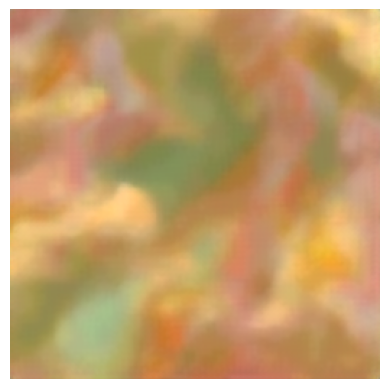

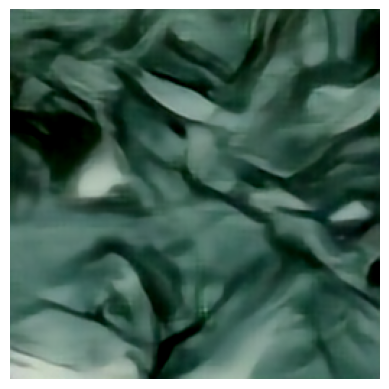

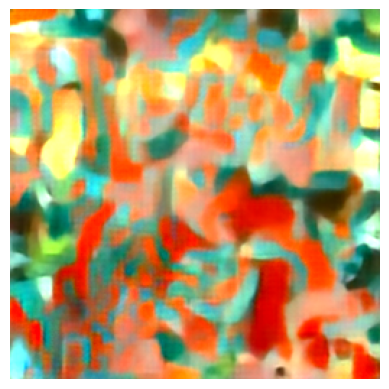

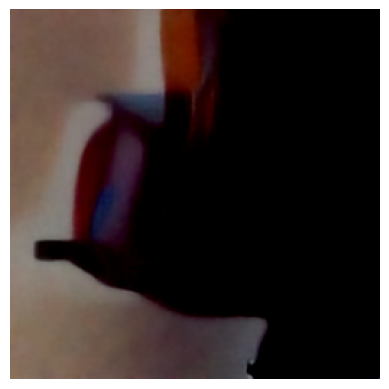

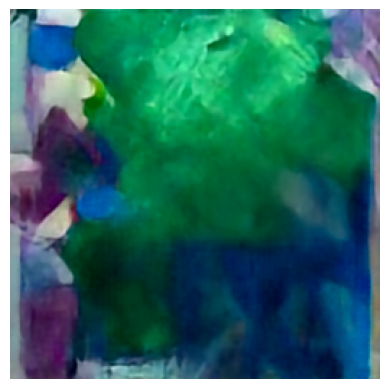

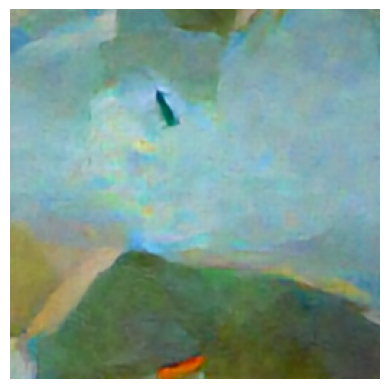

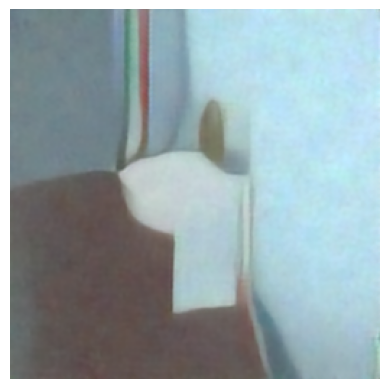

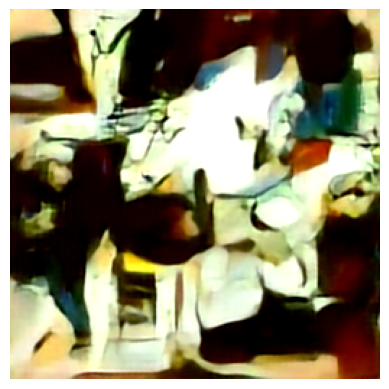

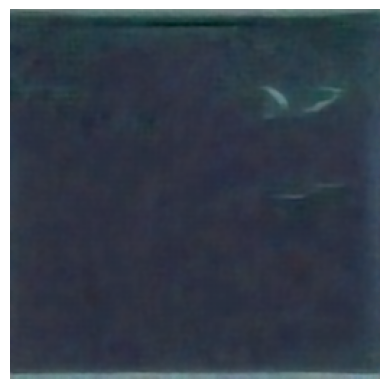

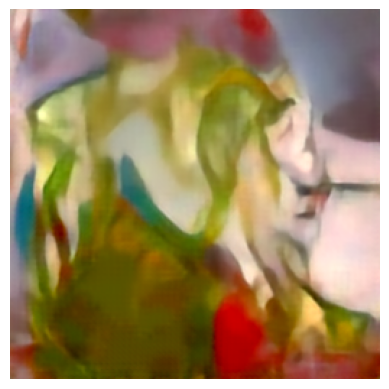

2


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

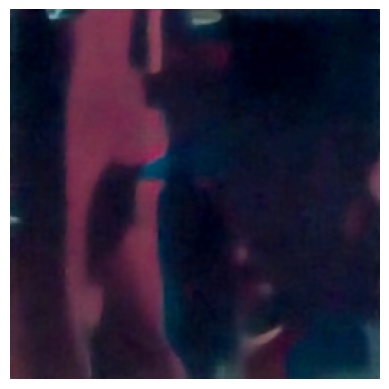

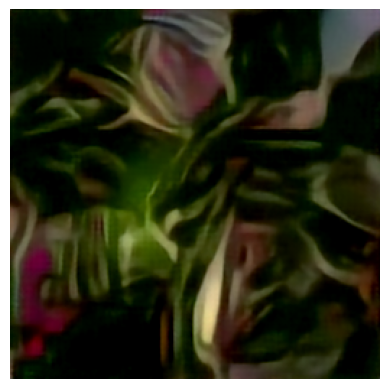

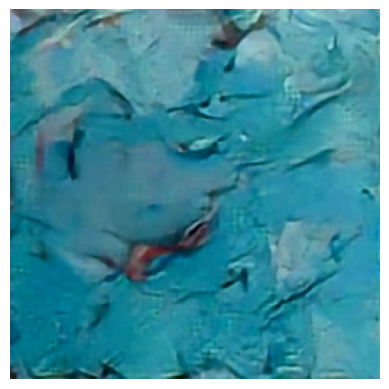

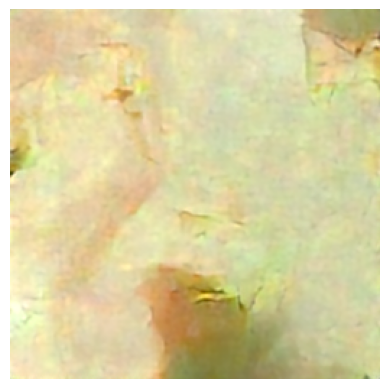

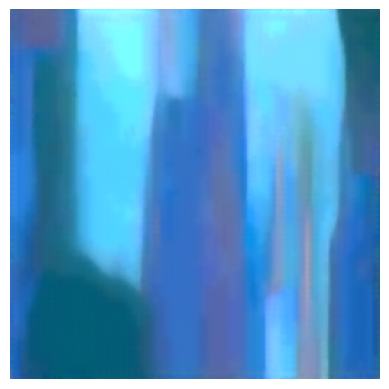

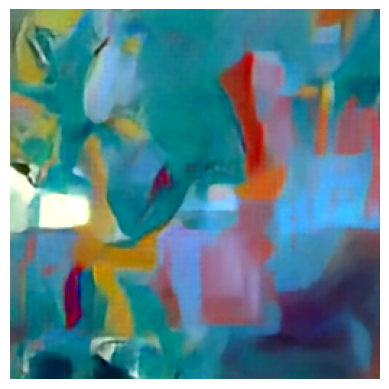

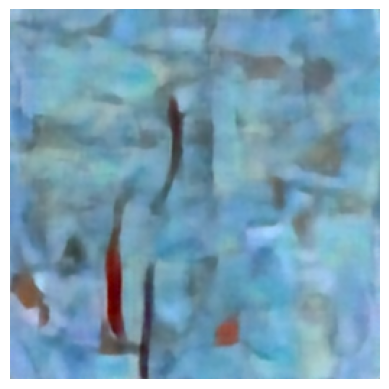

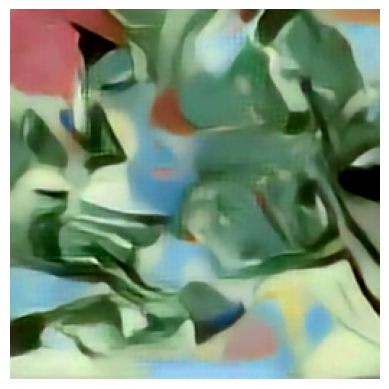

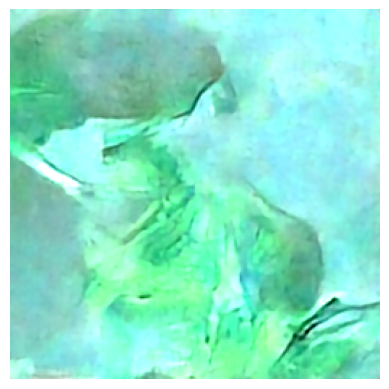

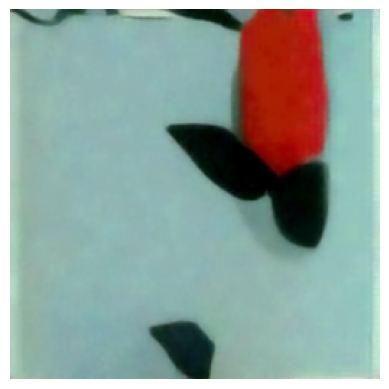

3


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [16]:
autoencoder = VQVAE().to(device)
model_32.eval()
model_64.eval()
autoencoder.eval()

path_32 = "/kaggle/input/ldm-32/model_ldm32_e99.pth"
checkpoint = torch.load(path_32, map_location = device)
model_32.load_state_dict(checkpoint['model_state_dict'])

path_64 = "/kaggle/input/ldm-64-new-conditioned/my_diff_e100.pth"
checkpoint = torch.load(path_64, map_location = device)
model_64.load_state_dict(checkpoint['model_state_dict'])

path = "/kaggle/input/t4-3070/vqvae_030.pth"
checkpoint = torch.load(path, map_location = device)
autoencoder.load_state_dict(checkpoint['model_state_dict'])

diff = Diffusion(device)

scheduler_32 = DDIMScheduler()
scheduler_32.set_timesteps(100)
scheduler_64 = DDIMScheduler()
scheduler_64.set_timesteps(50)


batch = 10
no = 1
while True:
    print(no)
    code32 = diff.sample(model_32, scheduler_32, 32, batch)
    condition = code32.to(device)
    condition = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)(condition)
    code64 = diff.sample(model_64, scheduler_64, 64, batch, condition)
    code32 = denormalization(code32, 'top')
    code64 = denormalization(code64, 'bot')
    img = autoencoder.decode_code(code32, code64)
    img = (img.clamp(-1, 1) + 1) / 2
    img = (img * 255).type(torch.uint8)
    save_images(img, no)
    show(img)
        
#     break
    
    no += 1